# TELCO CUSTOMER CHURN DATA ANALYSIS/PREDICTIONS

## Spark Session Setup

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("TelecomChurnProject").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/01 09:11:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Importing Dataset

In [4]:
df=spark.read.option("header",True).csv("customer_churn.csv")
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: string (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: string (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [5]:
df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|  

### Returning the total number of null values in each column of the dataset

In [6]:
from pyspark.sql.functions import *
df.select([count(when(col(iterator).isNull(), iterator)).alias(iterator) for iterator in df.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

### Changing Data-types of certain columns(tenure,MonthlyCharges,TotalCharges) to integer and float respectively from string

In [29]:
from pyspark.sql.types import *
#df.withColumn("tenure",col("tenure").cast("int"))
df = df.withColumn("tenure", df["tenure"].cast(IntegerType()))



In [34]:
df=df.withColumn("MonthlyCharges",df["MonthlyCharges"].cast(DoubleType()))
df=df.withColumn("TotalCharges",df["TotalCharges"].cast(DoubleType()))

In [38]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



### Performing encoding on Categorical columns so that they can be fed into a ML model

In [35]:
from pyspark.ml.feature import StringIndexer
indexer=StringIndexer(inputCol='gender', outputCol='gender_enc')
df_encoded=indexer.fit(df).transform(df)

list=['Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','Churn']
for i in list:
    indexer=StringIndexer(inputCol=i, outputCol=i+'_enc')
    df_encoded=indexer.fit(df_encoded).transform(df_encoded)


In [36]:
df_encoded.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+----------+-----------+--------------+----------------+-----------------+-------------------+------------------+----------------+--------------------+---------------+---------------+-------------------+------------+--------------------+-----------------+---------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|gender_enc|Partner_enc|Dependents_enc|PhoneService_enc|MultipleLines_enc|InternetService_enc|OnlineSecurity_enc

In [41]:
df=df.withColumn("SeniorCitizen",df["SeniorCitizen"].cast(IntegerType()))
df_encoded=df_encoded.withColumn("SeniorCitizen",df_encoded["SeniorCitizen"].cast(IntegerType()))
df_encoded.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)
 |-- gender_enc: double (nullable = false)
 |-- Partner_enc: double (nullable = fa

### We once again perform a function to check for null values. We notice we have 11 null values in the 'TotalCharges' column

In [56]:
from pyspark.sql.functions import *
df_encoded.select([count(when(col(iterator).isNull(), iterator)).alias(iterator) for iterator in df_encoded.columns]).show()


+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+----------+-----------+--------------+----------------+-----------------+-------------------+------------------+----------------+--------------------+---------------+---------------+-------------------+------------+--------------------+-----------------+---------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|gender_enc|Partner_enc|Dependents_enc|PhoneService_enc|MultipleLines_enc|InternetService_enc|OnlineSecurity_enc|OnlineBackup_enc|DeviceProtection_enc|TechSupport_enc|StreamingTV_enc|StreamingMovies_enc|Contract_en

### We drop the the 11 rows which have null values in TotalCharges. We can afford this because we have 7000+ rows of data

In [57]:
df_encoded = df_encoded.na.drop(subset=["TotalCharges"])

# Model Training

### We create an array of independent features we were going to feed our model and add it as a separate column called 'Features'

In [58]:
from pyspark.ml.feature import VectorAssembler
selected_features = [
    "gender_enc", "SeniorCitizen", "Partner_enc", "Dependents_enc", "PhoneService_enc",
    "MultipleLines_enc", "InternetService_enc", "OnlineSecurity_enc", "OnlineBackup_enc",
    "DeviceProtection_enc", "TechSupport_enc", "StreamingTV_enc", "StreamingMovies_enc",
    "Contract_enc", "PaperlessBilling_enc", "PaymentMethod_enc", "MonthlyCharges", "TotalCharges",
    "tenure"
]
assembler = VectorAssembler(inputCols=selected_features, outputCol="Features")
df_assembled = assembler.transform(df_encoded)

In [59]:
df_assembled.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+----------+-----------+--------------+----------------+-----------------+-------------------+------------------+----------------+--------------------+---------------+---------------+-------------------+------------+--------------------+-----------------+---------+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|gender_enc|Partner_enc|Dependents_enc|PhoneService_enc|MultipleLines_enc|InternetService_e

### We use Logistic Regression to train our model. This is because our problem is a classification one(Churn: Yes or No). We split our dataset in a 75/25 ratio (training/test)

In [65]:
from pyspark.ml.classification import LogisticRegression
train_data,test_data=df_assembled.randomSplit([0.75,0.25], seed=42)
regressor=LogisticRegression(featuresCol="Features",labelCol="Churn_enc",regParam=0.01)
model=regressor.fit(train_data)

### We create a 'predictions' dataframe with the predictions of our model by feeding it test data.

In [66]:
predictions=model.transform(test_data)

In [67]:
predictions.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+----------+-----------+--------------+----------------+-----------------+-------------------+------------------+----------------+--------------------+---------------+---------------+-------------------+------------+--------------------+-----------------+---------+--------------------+--------------------+--------------------+----------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|gender_enc|Partner_enc|Dependents_enc

## Model Evaluation

### We evaluate our model on the Accuracy parameter(It achieves an Accuracy of 85.2%)

In [68]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='Churn_enc')
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8519921282350036


### We evaluate our model on Area Under PR curvei.e F1 score. (It scores 67.5%)

In [72]:
precision_evaluator = BinaryClassificationEvaluator(labelCol='Churn_enc',rawPredictionCol='rawPrediction',metricName='areaUnderPR')
precision=precision_evaluator.evaluate(predictions)
print(f'AreaUnderPR(F1-Score): {precision}')



AreaUnderPR(F1-Score): 0.6748319360667101


## Visualization

### Churn Distribution(%)

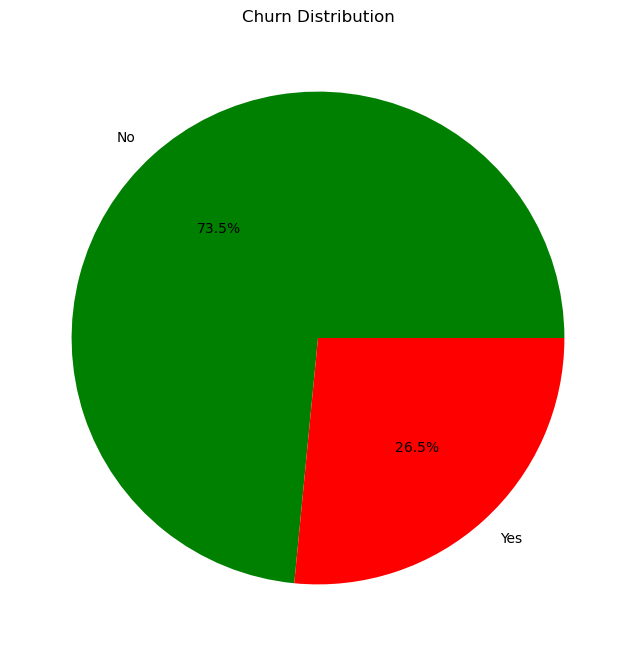

In [82]:
import matplotlib.pyplot as plt
churn_distribution = df.groupBy("Churn").count().toPandas()

plt.figure(figsize=(8, 8))
plt.pie(churn_distribution["count"], labels=churn_distribution["Churn"], autopct='%1.1f%%', colors=['green', 'red'])
plt.title('Churn Distribution')
plt.show()


### Churn Distribution by Senior Citizenship

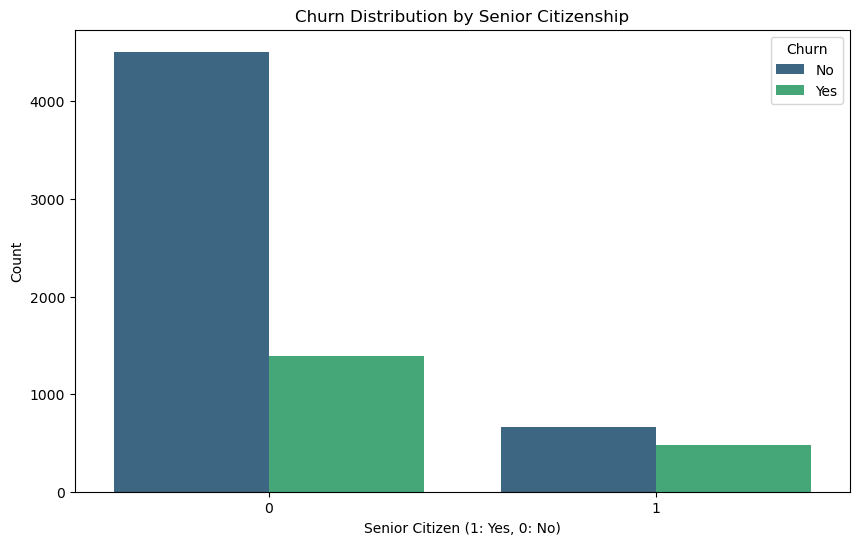

In [83]:
import seaborn as sns
senior_churn_distribution = df.groupBy("SeniorCitizen", "Churn").count().toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="SeniorCitizen", y="count", hue="Churn", data=senior_churn_distribution, palette="viridis")
plt.title('Churn Distribution by Senior Citizenship')
plt.xlabel('Senior Citizen (1: Yes, 0: No)')
plt.ylabel('Count')
plt.show()

### Churn Distribution by Conract Type

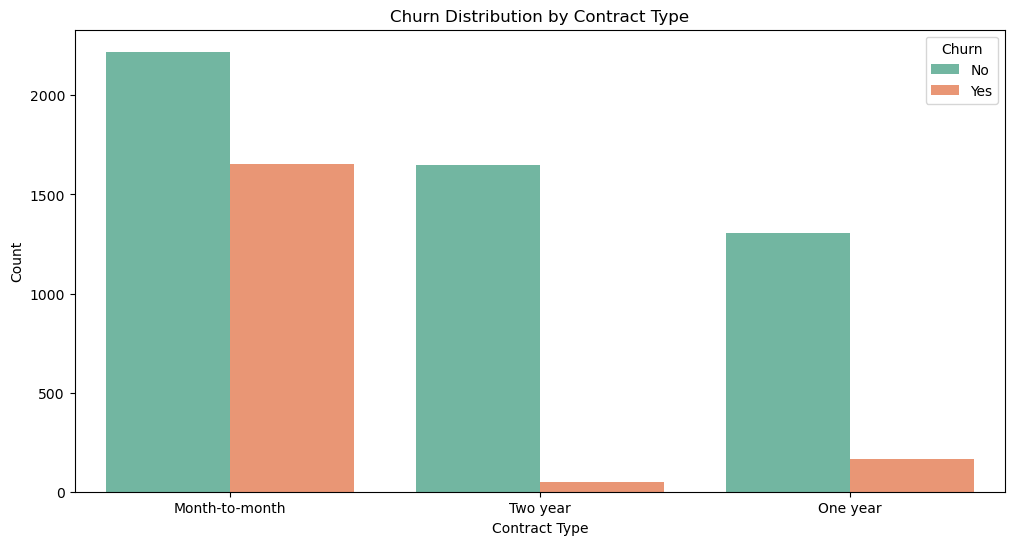

In [84]:
contract_churn_distribution = df.groupBy("Contract", "Churn").count().toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x="Contract", y="count", hue="Churn", data=contract_churn_distribution, palette="Set2")
plt.title('Churn Distribution by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.show()

### Tenure Distribution by Churn(KPED graph)

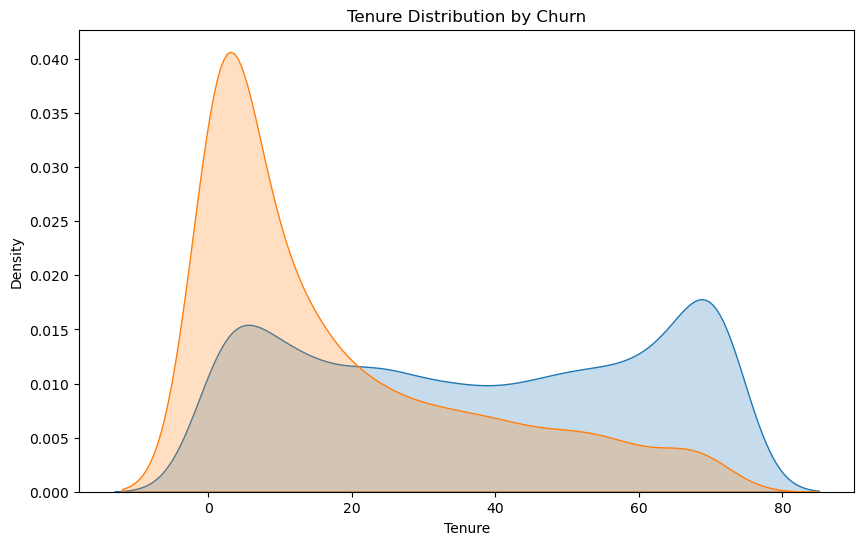

In [87]:
tenure_no_churn = df.filter(df['Churn'] == 'No').select('tenure').rdd.flatMap(lambda x: x).collect()
tenure_churn = df.filter(df['Churn'] == 'Yes').select('tenure').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
sns.kdeplot(tenure_no_churn, label='No Churn', fill=True)
sns.kdeplot(tenure_churn, label='Churn', fill=True)
plt.title('Tenure Distribution by Churn')
plt.xlabel('Tenure')
plt.ylabel('Density')
plt.show()


### Tenure and Monthly Charges Distribution(Histogram)

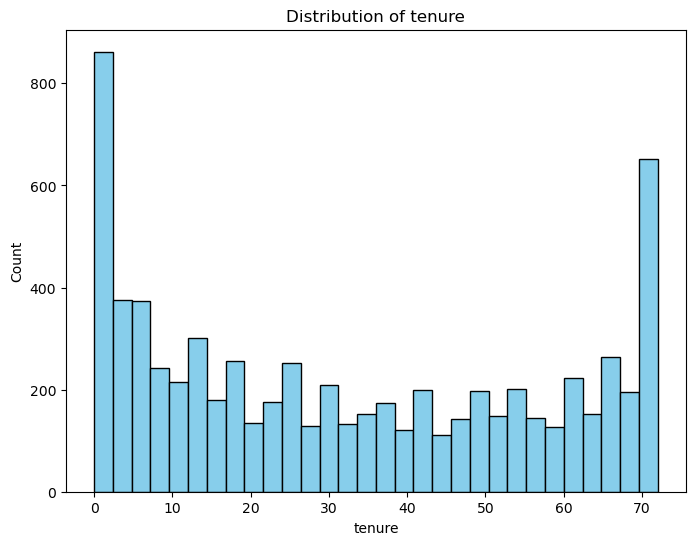

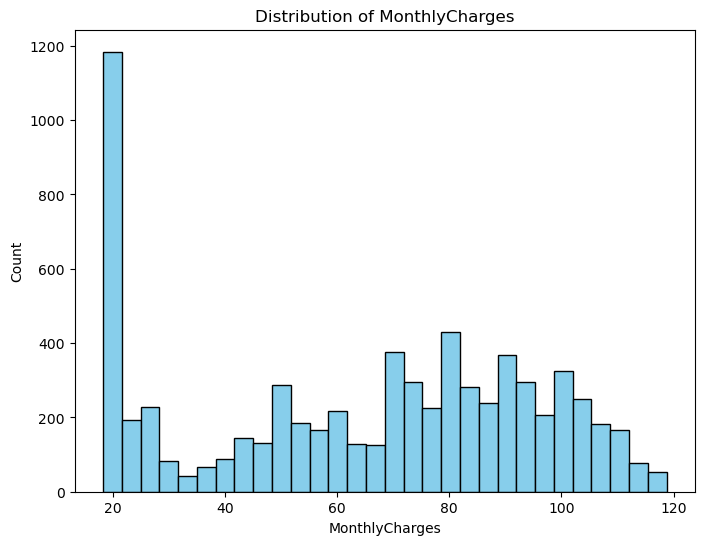

In [90]:
numeric_features = ["tenure", "MonthlyCharges"]

for i in numeric_features:
    plt.figure(figsize=(8, 6))
    plt.hist(df.select(i).rdd.flatMap(lambda x: x).collect(), bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {i}')
    plt.xlabel(i)
    plt.ylabel('Count')
    plt.show()


### Confusion Matrix

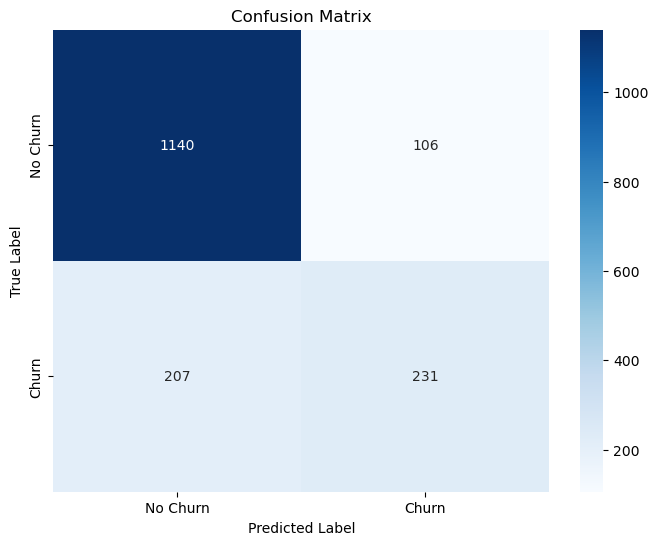

In [94]:
from sklearn.metrics import confusion_matrix
true_labels = predictions.select("Churn_enc").rdd.flatMap(lambda x: x).collect()
predicted_labels = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Integration with MongoDB

### Connecting to MongoDB

In [99]:
from pymongo import MongoClient
mongo_uri ="mongodb://localhost:27017/bdt_project_telecom_churn"
client = MongoClient(mongo_uri)


### Selecting our MongoDB database and collection. We also convert PySpark dataframe to a Pandas dataframe

In [100]:
db = client["bdt_project_telecom_churn"]
collection = db["Telecom_Churn_Predictions"]
predictions_data = predictions.select("customerID", "prediction").toPandas()


### We convert the Pandas dataframe to a list of dictionaries

In [101]:
data_to_insert = predictions_data.to_dict(orient="records")


### We Insert our Data into our MongoDB collection

In [102]:
collection.insert_many(data_to_insert)

InsertManyResult([ObjectId('656a113337645cf006a862b4'), ObjectId('656a113337645cf006a862b5'), ObjectId('656a113337645cf006a862b6'), ObjectId('656a113337645cf006a862b7'), ObjectId('656a113337645cf006a862b8'), ObjectId('656a113337645cf006a862b9'), ObjectId('656a113337645cf006a862ba'), ObjectId('656a113337645cf006a862bb'), ObjectId('656a113337645cf006a862bc'), ObjectId('656a113337645cf006a862bd'), ObjectId('656a113337645cf006a862be'), ObjectId('656a113337645cf006a862bf'), ObjectId('656a113337645cf006a862c0'), ObjectId('656a113337645cf006a862c1'), ObjectId('656a113337645cf006a862c2'), ObjectId('656a113337645cf006a862c3'), ObjectId('656a113337645cf006a862c4'), ObjectId('656a113337645cf006a862c5'), ObjectId('656a113337645cf006a862c6'), ObjectId('656a113337645cf006a862c7'), ObjectId('656a113337645cf006a862c8'), ObjectId('656a113337645cf006a862c9'), ObjectId('656a113337645cf006a862ca'), ObjectId('656a113337645cf006a862cb'), ObjectId('656a113337645cf006a862cc'), ObjectId('656a113337645cf006a862

## Stopping the Spark Session

In [103]:
spark.stop()